1. 키와 몸무게는 스트레스와 상관이 없을지도 모른다 - 단순 제거 시 지표 상승 확인
2. 1은 의도되었을지도 모른다. 뚱뚱하거나 마른 사람 중에서도 다양한, 혹은 일부러 균등한 표본을 구성했을수도. 그러니 점수 기반 분석을 해보는 것은 어떨까?

In [67]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# 📦 분석 환경 셋업 및 CSV 파일 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import os

# 👉 불러올 CSV 경로를 설정하세요
csv_path = "../datasets/DACON_Stress/train.csv"  # 예: "data/train.csv" 또는 "hand_data.csv"

# CSV 로드
df = pd.read_csv(csv_path)

# 간단한 확인
print(f"✅ 데이터 로드 완료: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()
df.dropna()

✅ 데이터 로드 완료: 3000 rows, 18 columns


,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
12,TRAIN_0012,F,32,160.00,69.84,216.29,124,100,114.40,1.36,moderate,ex-smoker,high blood pressure,high blood pressure,sleep difficulty,graduate degree,8.0,0.59
25,TRAIN_0025,F,39,163.05,94.85,223.32,155,92,135.58,0.87,moderate,ex-smoker,high blood pressure,high blood pressure,normal,bachelors degree,9.0,0.54
26,TRAIN_0026,M,53,170.80,83.19,228.00,162,89,149.90,0.87,moderate,current-smoker,high blood pressure,diabetes,normal,high school diploma,10.0,0.89
38,TRAIN_0038,M,42,175.87,108.00,236.10,140,95,123.40,1.25,moderate,ex-smoker,heart disease,diabetes,normal,bachelors degree,8.0,0.97
39,TRAIN_0039,F,39,155.80,61.30,242.55,115,105,122.29,1.09,light,current-smoker,diabetes,high blood pressure,normal,high school diploma,8.0,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,TRAIN_2978,F,63,164.28,68.46,232.70,171,98,146.09,0.78,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,high school diploma,10.0,0.24
2982,TRAIN_2982,M,34,180.74,72.79,204.84,133,98,129.97,1.51,intense,ex-smoker,high blood pressure,diabetes,oversleeping,graduate degree,9.0,0.11
2985,TRAIN_2985,F,52,170.88,58.70,218.21,137,103,145.82,1.13,intense,current-smoker,heart disease,diabetes,oversleeping,bachelors degree,8.0,0.03
2993,TRAIN_2993,M,37,180.60,82.64,215.41,136,78,130.09,1.08,moderate,non-smoker,heart disease,high blood pressure,sleep difficulty,bachelors degree,7.0,0.08


### Traits  
클라스 값 - 성별, 활동성, 흡연여부, 과거 질병이력, 가족력, 수면패턴, 최종학력
숫자 값 - 나이, 신장, 무게, 콜레스테롤, 혈압, 이완혈압, 혈당, 골밀도, 평균근로시간. 

#### 범주형 값에 적용 가능한 것  
##### 대한민국 전체 평균을 적용 가능한가 
정규화 - 0을 평균, 1을 범위로 가지는 분포.
드는 생각 - 나이, 신장, 무게 등 이 표본이 가지고 있는 데이터의 편향성이 있을수 있음. 대한민국 전체의 표준과 표준편차 등을 대입하여 이 데이터의 편향성 확인, 
혹은 학습 시에도 고려하여 정규화 진행 - 모델이 좀 더 다양한 사람을 수용 가능하도록.

#### 속성값에 대한 처리  
##### 단순 인덱싱을 할 것인가 범주형과 비슷하게 의미를 부여할 것인가?  
범주화가 어려운 경우도 있겟지만, 학력의 경우 취득 기간을 매개로 고학력자를 판단, 수면의 경우도 수면 부족 등을 척도로 나열, 혈압 등도 비슷한 접근이 가능할거 같다. 

#### 아주 나이브한 예측기 생성, 비교실험
1. 깡데이터 학습
2. 변수 실험 : 
대한민국 평균 / 데이터셋(train 군에서만) 평균
단순 인덱싱 / 유사 범주형 인덱싱




In [69]:
# 📊 컬럼 타입별 요약 통계 출력

def summarize_dataframe(df):
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

    print("🔢 [숫자형 컬럼 통계 요약]")
    display(df[numeric_cols].agg(["mean", "std","max","min"]).T.rename(columns={"mean": "평균", "std": "표준편차","max": "최대값","min": "최소값"}))

    print("\n🔠 [범주형/문자형 컬럼 유니크 값 보기]")
    for col in categorical_cols:
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)}개 유니크 값 → {unique_vals[:10]}{' ...' if len(unique_vals) > 10 else ''}")

# ✅ 실행
summarize_dataframe(df)

🔢 [숫자형 컬럼 통계 요약]


,평균,표준편차,최대값,최소값
age,53.068000,20.672070,89.00,17.00
height,168.585687,9.351876,195.28,141.13
weight,72.486680,13.167222,120.88,36.32
cholesterol,233.910523,24.333434,313.35,148.81
systolic_blood_pressure,146.144333,15.845310,191.00,97.00
diastolic_blood_pressure,95.504000,9.895283,124.00,60.00
glucose,126.467720,18.536844,185.74,70.05
bone_density,0.933367,0.444783,2.00,-0.22
mean_working,8.716972,1.628944,16.00,4.00
stress_score,0.482130,0.288252,1.00,0.00



🔠 [범주형/문자형 컬럼 유니크 값 보기]
ID: 3000개 유니크 값 → ['TRAIN_0000' 'TRAIN_0001' 'TRAIN_0002' 'TRAIN_0003' 'TRAIN_0004'
 'TRAIN_0005' 'TRAIN_0006' 'TRAIN_0007' 'TRAIN_0008' 'TRAIN_0009'] ...
gender: 2개 유니크 값 → ['F' 'M']
activity: 3개 유니크 값 → ['moderate' 'light' 'intense']
smoke_status: 3개 유니크 값 → ['ex-smoker' 'non-smoker' 'current-smoker']
medical_history: 3개 유니크 값 → ['high blood pressure' 'diabetes' 'heart disease']
family_medical_history: 3개 유니크 값 → ['diabetes' 'high blood pressure' 'heart disease']
sleep_pattern: 3개 유니크 값 → ['sleep difficulty' 'normal' 'oversleeping']
edu_level: 3개 유니크 값 → ['bachelors degree' 'graduate degree' 'high school diploma']


In [70]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

def generate_datasets(df, external_stats=None):
    datasets = {}

    # target 분리
    target_col = 'stress_score'
    y = df[target_col].copy()

    for normalize_target in [True, False]:
        # 1. 정답 정규화 여부에 따라 복사
        target_processed = (y - y.mean()) / y.std() if normalize_target else y
        suffix = '_T' if normalize_target else '_F'

        for i in range(5):
            temp_df = df.copy()

            # target 컬럼 제거
            temp_df = temp_df.drop(columns=[target_col])

            # 숫자/범주형 분리
            num_cols = temp_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
            cat_cols = temp_df.select_dtypes(include=['object', 'category']).columns.tolist()

            # df1: 일반 정규화
            if i == 1:
                scaler = StandardScaler()
                temp_df[num_cols] = scaler.fit_transform(temp_df[num_cols])

            # df2: 외부 기준 정규화
            # elif i == 2 and external_stats:
            #     for col in num_cols:
            #         if col in external_stats:
            #             mean, std = external_stats[col]
            #             temp_df[col] = (temp_df[col] - mean) / std
            #         else:
            #             # fallback: 내부 기준
            #             temp_df[col] = (temp_df[col] - temp_df[col].mean()) / temp_df[col].std()

            # df3: 레이블 인코딩
            elif i == 2:
                for col in cat_cols:
                    temp_df[col] = LabelEncoder().fit_transform(temp_df[col])

            # df4: 원핫 인코딩
            elif i == 3:
                temp_df = pd.get_dummies(temp_df, columns=cat_cols)

            # df5: 혼합 인코딩 - placeholder (당장은 df3과 동일 처리, 이후 수정 가능)
            elif i == 4:
                for col in cat_cols:
                    temp_df[col] = LabelEncoder().fit_transform(temp_df[col])

            # df0: 아무것도 안 함 (그대로)

            # 정답 열 다시 붙이기
            temp_df[target_col] = target_processed

            # 저장
            datasets[f'df{i}{suffix}'] = temp_df

    return datasets

In [ ]:
# 대한민국 평균, 표준편차 딕셔너리 (수동 입력 예시)
# external_stats = {
#     'age': (42.0, 11.5),
#     'height': (167.2, 7.8),
#     'weight': (66.1, 9.3)
# }

# 생성
datasets = generate_datasets(df)

# 예: df3_T 확인
df3_T = datasets['df3_T']


In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import wandb
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import shap
from sklearn.ensemble import RandomForestRegressor
OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# 모델 훈련

def train_sgd_regressor_with_wandb(df, target_column='target', project='SGD-Regression', run_name=None, input_epochs = 50):
    # wandb 설정
    wandb.init(project=project, name=run_name)
    
    df = df.fillna(0)  # 결측값 처리 (수치형을 가정)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 특성 분류
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # 전처리
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 전처리 적용
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_val_transformed = preprocessor.transform(X_val)

    # SGDRegressor 초기화
    reg = SGDRegressor(loss='squared_error', max_iter=1, warm_start=True, random_state=42)

    epochs = input_epochs

    for epoch in range(epochs):
        reg.fit(X_train_transformed, y_train)  # warm_start로 누적 학습

        # 예측 및 평가
        y_pred = reg.predict(X_val_transformed)
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # wandb 기록
        wandb.log({'epoch': epoch + 1, 'mse': mse, 'mae': mae, 'r2': r2})

    print("✅ Final MSE:", round(mse, 4))
    print("✅ Final MAE:", round(mae, 4))
    print("✅ Final R² Score:", round(r2, 4))
    wandb.finish()

    # SHAP explainer 생성
    explainer = shap.Explainer(reg, X_train_transformed)

    # SHAP 값 계산
    shap_values = explainer(X_val_transformed)

    # 요약 플롯 시각화
    shap.summary_plot(shap_values, X_val_transformed)
    # shap.summary_plot(shap_values, X_val_transformed, feature_names=X_val_transformed.columns)

    return reg  # 훈련된 모델 반환

In [132]:
def detect_mixed_type_columns(df):
    mixed_cols = []
    for col in df.columns:
        types = df[col].map(type).nunique()
        if types > 1:
            mixed_cols.append((col, types))
    return mixed_cols
def fill_missing_values(df):
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(-1)
        elif df[col].dtype == 'object':
            df[col] = df[col].fillna("N/A")
    return df

# # 사용 예시
# mixed_columns = detect_mixed_type_columns(datasets['df0_F'])
# print("타입이 섞인 컬럼:", mixed_columns)
# 예시 실행
for i in range(5):
    for target_norm in ['T', 'F']:
        df_name = f"df{i}_{target_norm}"
        fill_missing_values(datasets[df_name])
        print(f"\n=== Training on {df_name} ===")
        model = train_sgd_regressor_with_wandb(datasets[df_name], target_column = 'stress_score', project = 'A_B test', run_name= df_name, input_epochs=300)


=== Training on df0_T ===


✅ Final MSE: 0.9517
✅ Final MAE: 0.8401
✅ Final R² Score: -0.0012


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
mae,▇█████▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
mse,▄███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
r2,▃▁▁▁▁▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch,300
mae,0.84014
mse,0.95174
r2,-0.00123


AttributeError: 'csr_matrix' object has no attribute 'columns'

In [85]:
datasets['df0_F']['medical_history'] = datasets['df0_F']['medical_history'].fillna('N/A')
datasets['df0_F']['family_medical_history'] = datasets['df0_F']['family_medical_history'].fillna('N/A')
datasets['df0_F']['edu_level'] = datasets['df0_F']['edu_level'].fillna('N/A')

In [97]:
fill_missing_values(datasets['df1_F'])

,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
0,TRAIN_0000,F,0.915978,-0.758871,-1.064691,1.887820,1.190182,0.454434,0.910894,-0.142490,moderate,ex-smoker,high blood pressure,diabetes,sleep difficulty,bachelors degree,-1.000000,0.63
1,TRAIN_0001,M,1.690098,1.206837,0.388402,0.964245,2.010751,1.566260,1.104594,-1.941420,moderate,ex-smoker,N/A,diabetes,normal,graduate degree,-1.000000,0.83
2,TRAIN_0002,M,-0.293585,1.484903,1.324974,-0.298015,-0.766559,-0.050942,0.870967,0.554595,light,ex-smoker,N/A,N/A,normal,high school diploma,0.173794,0.70
3,TRAIN_0003,M,0.770830,1.838902,-0.292949,-1.116778,0.748338,-0.354167,0.582304,-1.019468,intense,ex-smoker,high blood pressure,N/A,oversleeping,graduate degree,-1.000000,0.17
4,TRAIN_0004,F,1.351420,-0.423054,-0.072668,0.904646,1.568906,2.071635,0.156594,-1.334281,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,bachelors degree,-1.000000,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,TRAIN_2995,F,1.641715,0.625039,0.353461,-0.024683,1.884510,1.566260,0.444717,-1.649093,light,non-smoker,N/A,N/A,oversleeping,N/A,-1.000000,0.02
2996,TRAIN_2996,M,-1.358000,0.305264,-1.581211,-1.521639,-0.198472,-0.960618,-0.785471,1.836332,moderate,current-smoker,N/A,N/A,normal,high school diploma,0.173794,0.16
2997,TRAIN_2997,F,0.045093,-0.690424,-1.287250,-0.961411,1.127062,-0.455242,0.539679,-0.299897,light,current-smoker,N/A,N/A,normal,N/A,0.173794,0.16
2998,TRAIN_2998,M,0.819213,1.361912,0.737812,0.007788,2.263234,-0.455242,0.993985,-0.794602,moderate,non-smoker,N/A,N/A,oversleeping,high school diploma,-1.000000,0.18


In [100]:
datasets['df3_F']

,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,mean_working,ID_TRAIN_0000,...,family_medical_history_diabetes,family_medical_history_heart disease,family_medical_history_high blood pressure,sleep_pattern_normal,sleep_pattern_oversleeping,sleep_pattern_sleep difficulty,edu_level_bachelors degree,edu_level_graduate degree,edu_level_high school diploma,stress_score
0,72,161.49,58.47,279.84,165,100,143.35,0.87,-1.0,True,...,True,False,False,False,False,True,True,False,False,0.63
1,88,179.87,77.60,257.37,178,111,146.94,0.07,-1.0,False,...,True,False,False,True,False,False,False,True,False,0.83
2,47,182.47,89.93,226.66,134,95,142.61,1.18,9.0,False,...,False,False,False,True,False,False,False,False,True,0.70
3,69,185.78,68.63,206.74,158,92,137.26,0.48,-1.0,False,...,False,False,False,False,True,False,False,True,False,0.17
4,81,164.63,71.53,255.92,171,116,129.37,0.34,-1.0,False,...,True,False,False,False,False,True,True,False,False,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,87,174.43,77.14,233.31,176,111,134.71,0.20,-1.0,False,...,False,False,False,False,True,False,False,False,False,0.02
2996,25,171.44,51.67,196.89,143,86,111.91,1.75,9.0,False,...,False,False,False,True,False,False,False,False,True,0.16
2997,54,162.13,55.54,210.52,164,91,136.47,0.80,9.0,False,...,False,False,False,True,False,False,False,False,False,0.16
2998,70,181.32,82.20,234.10,182,91,144.89,0.58,-1.0,False,...,False,False,False,False,True,False,False,False,True,0.18


In [102]:
datasets['df1_withBMI'] = df.copy()

In [103]:
datasets['df1_withBMI']['BMI'] = datasets['df1_withBMI']['weight'] / (datasets['df1_withBMI']['height']/100)**2

✅ Final MSE: 0.92
✅ Final MAE: 0.8262
✅ Final R² Score: 0.0322


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
mae,▇████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁
mse,█▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
r2,▃▁▁▁▁▂▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████████
epoch,500
mae,0.8262
mse,0.91997
r2,0.0322


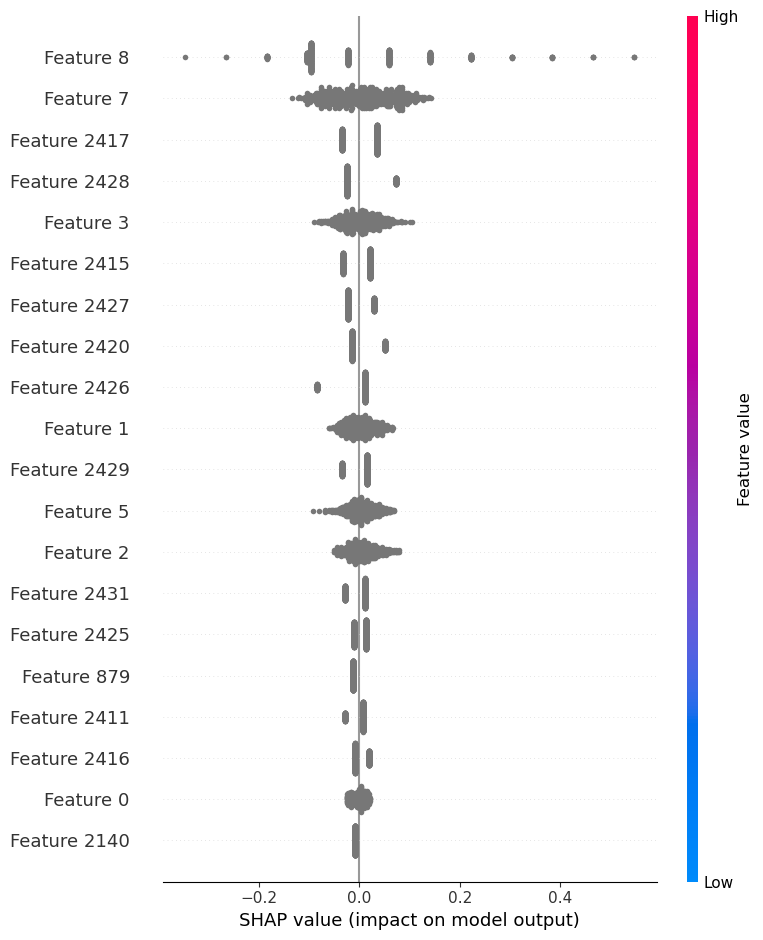

In [136]:
fill_missing_values(datasets['df1_ampedWorktime'])
model = train_sgd_regressor_with_wandb(datasets['df1_ampedWorktime'], target_column = 'stress_score', project = 'A_B test', run_name= 'df1_ampedWorktime',input_epochs=500)

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, figsize=(10, 8), cmap='coolwarm'):
    """
    숫자형 컬럼 간의 상관관계를 히트맵으로 출력하는 함수.

    Parameters:
    - df: 분석할 pandas DataFrame
    - figsize: 히트맵 크기
    - cmap: 색상 맵 ('coolwarm', 'viridis', 등)

    Returns:
    - None (히트맵 시각화)
    """
    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    if numeric_df.shape[1] < 2:
        print("📉 숫자형 컬럼이 2개 이상 있어야 상관관계 분석이 가능합니다.")
        return

    corr_matrix = numeric_df.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, square=True)
    plt.title("📊 Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

/var/folders/bf/66723k5s715dfg_n2knp_y0w0000gn/T/ipykernel_77817/689752813.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/model-playground-mac/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


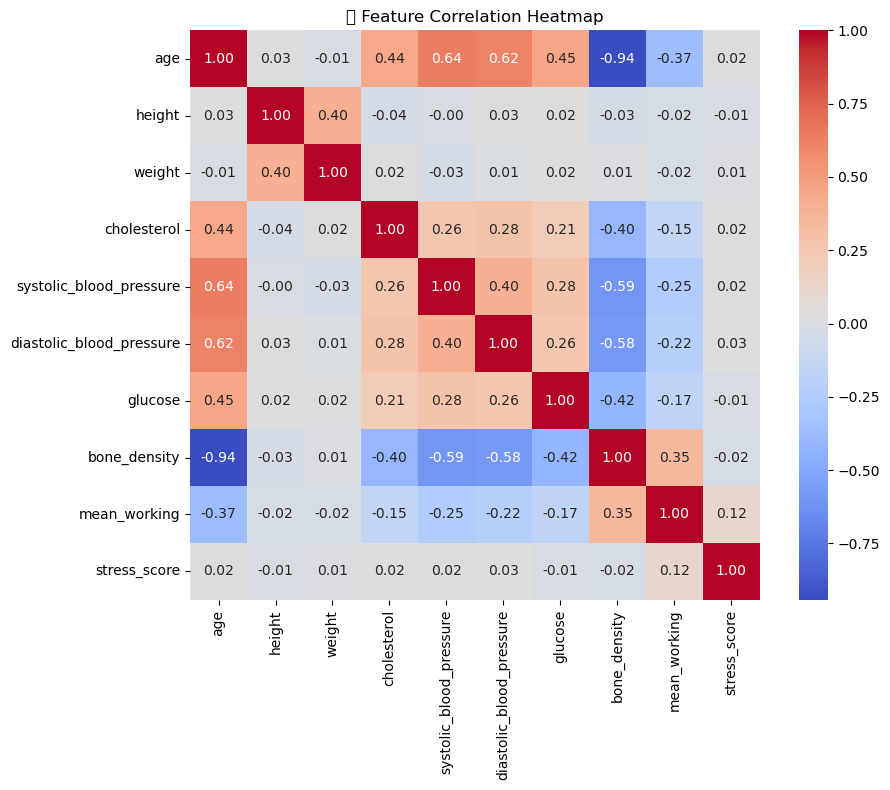

In [108]:
plot_correlation_heatmap(datasets['df1_T'])

In [133]:
datasets['df1_ampedWorktime'] = datasets['df1_T'].copy()
datasets['df1_ampedWorktime']['mean_working'] = datasets['df1_ampedWorktime']['mean_working']*1.2